In [1]:
# # %pip install xgboost
# %pip install xgboost==1.5.0


In [9]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Chnage scientific figures to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
sns.set(rc={'figure.figsize':(8,6)})

from pandas import to_datetime
import itertools
import warnings
import datetime
warnings.filterwarnings('ignore')

from math import sqrt
import warnings
import seaborn as sns
from itertools import product

from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn .dummy import DummyClassifier
import xgboost
from sklearn.model_selection import RandomizedSearchCV


In [10]:
# import graphviz

In [11]:
#Load Data

def data_ingestion():
    Features=pd.read_csv("Selected_Feats.csv")["Selected_Features"].tolist()
    Features.append("Dpd")
    data=pd.read_csv("ISW_data_for_Feature_analysis.csv")
    data=data.loc[:,Features]
    print(f'data info \n\n {data.info()}')
    return data
data=data_ingestion()





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 11 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   min_credit_amt_last_3_months                        2420 non-null   float64
 1   debits_lowest_negative_balance_last_9_months        2420 non-null   float64
 2   debits_min_debit_amt_last_3_months                  2420 non-null   float64
 3   credits_average_transaction_size_last_3_months      2420 non-null   float64
 4   debits_highest_negative_balance_last_6_months       2420 non-null   float64
 5   debits_average_transaction_size_last_12_months      2420 non-null   float64
 6   debits_highest_negative_balance_last_9_months       2420 non-null   float64
 7   debits_lowest_negative_balance_last_6_months        2420 non-null   float64
 8   credits_average_daily_transactions_last_3_months    2420 non-null   float64
 9

### Problem Formulation

This model is meant to clasiffy loan applicants into bad or good

#### Data Pre_processing

In [14]:
def data_pre_processing(data):
    print(f'Null Values \n\n{data.isnull().sum()}')
    print('\n\n Value Counts \n')
    for col in data.columns:
       y=data[col].nunique()
       print (f'{col}: {y}')
rr=data_pre_processing(data)
     
  


Null Values 

min_credit_amt_last_3_months                          0
debits_lowest_negative_balance_last_9_months          0
debits_min_debit_amt_last_3_months                    0
credits_average_transaction_size_last_3_months        0
debits_highest_negative_balance_last_6_months         0
debits_average_transaction_size_last_12_months        0
debits_highest_negative_balance_last_9_months         0
debits_lowest_negative_balance_last_6_months          0
credits_average_daily_transactions_last_3_months      0
debits_unique_negative_balance_dates_last_9_months    0
Dpd                                                   0
dtype: int64


 Value Counts 

min_credit_amt_last_3_months: 5
debits_lowest_negative_balance_last_9_months: 2
debits_min_debit_amt_last_3_months: 14
credits_average_transaction_size_last_3_months: 5
debits_highest_negative_balance_last_6_months: 2
debits_average_transaction_size_last_12_months: 25
debits_highest_negative_balance_last_9_months: 2
debits_lowest_negativ

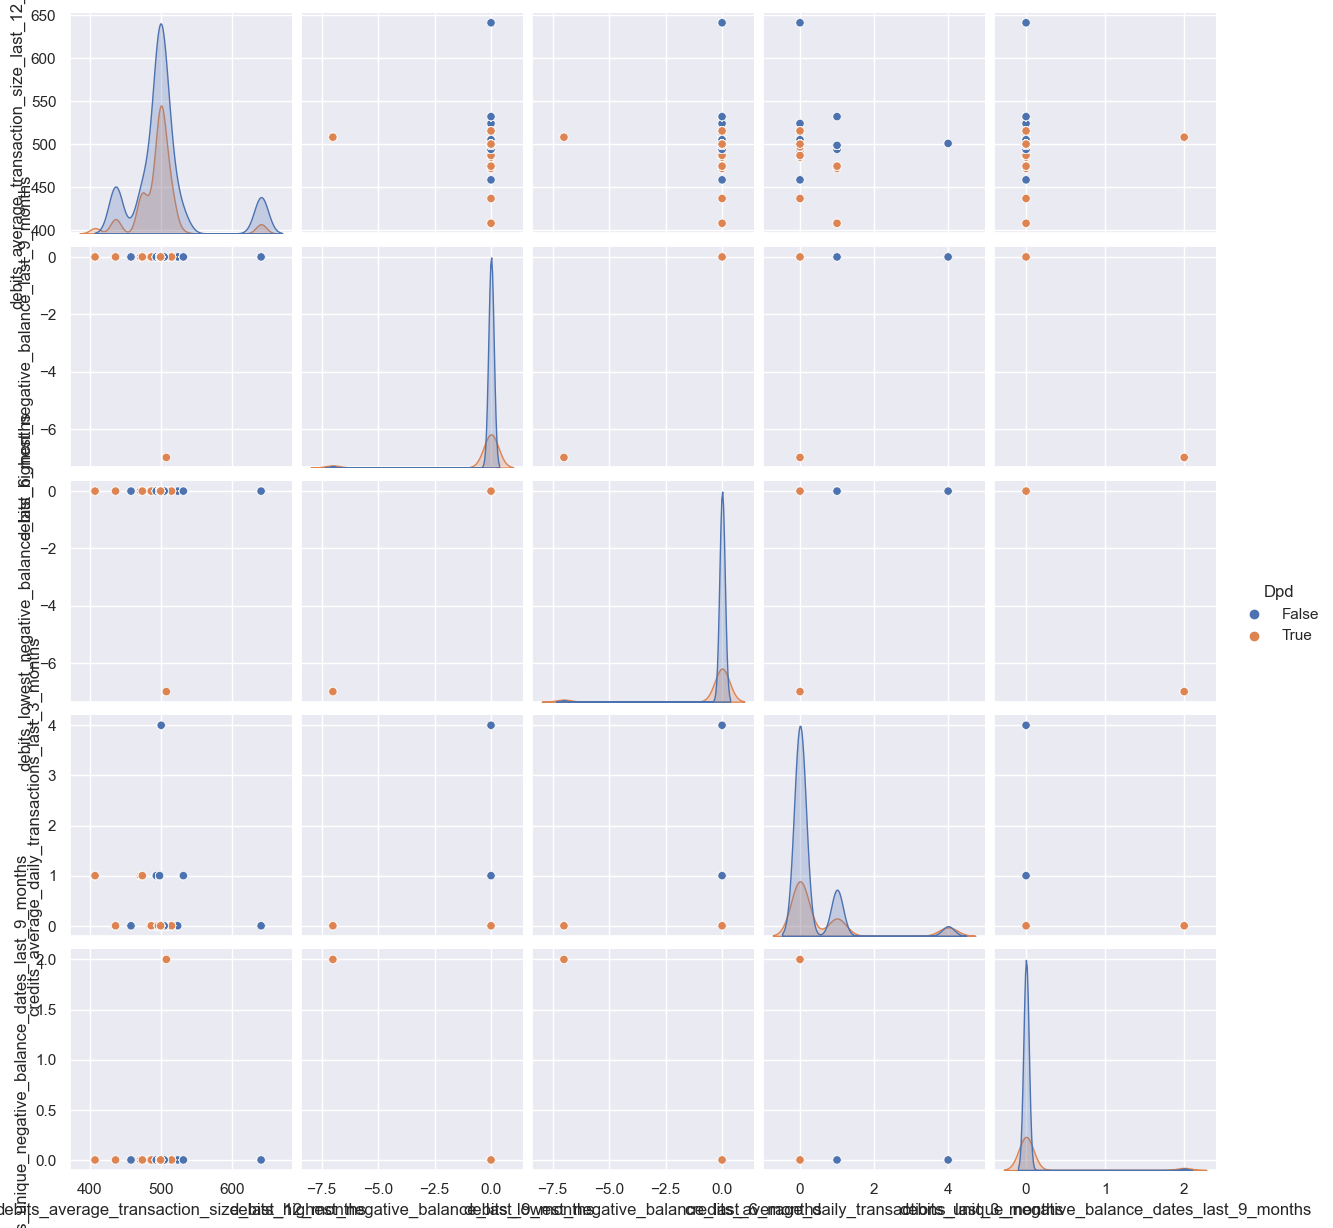

In [15]:
#Feature Relationships
def Feature_Relationships(data):
    data
    pairplot=sns.pairplot(data.iloc[:,5:],hue="Dpd",diag_kws={'bw':0.2})
   
    return pairplot

Rel=Feature_Relationships(data)
Rel
    

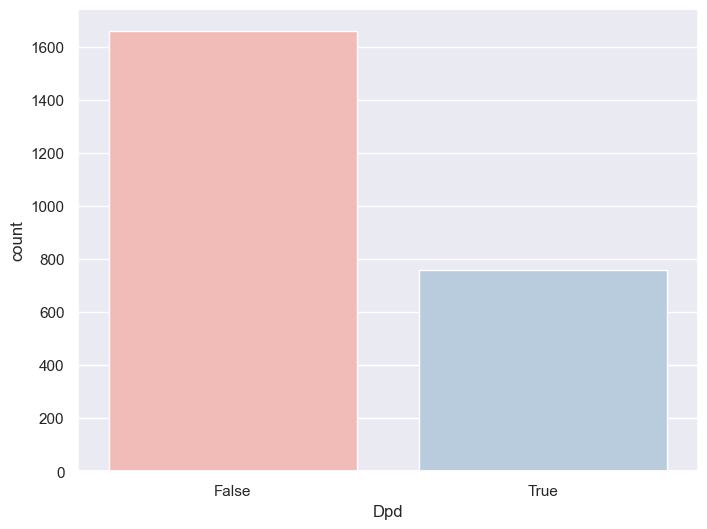

In [17]:
# Investiate distribution of y
def check_data_balance(data):
    plot = sns.set_theme(style="darkgrid", palette="Pastel1"); sns.countplot(x="Dpd", data=data)
    return plot

balance_plot=check_data_balance(data)


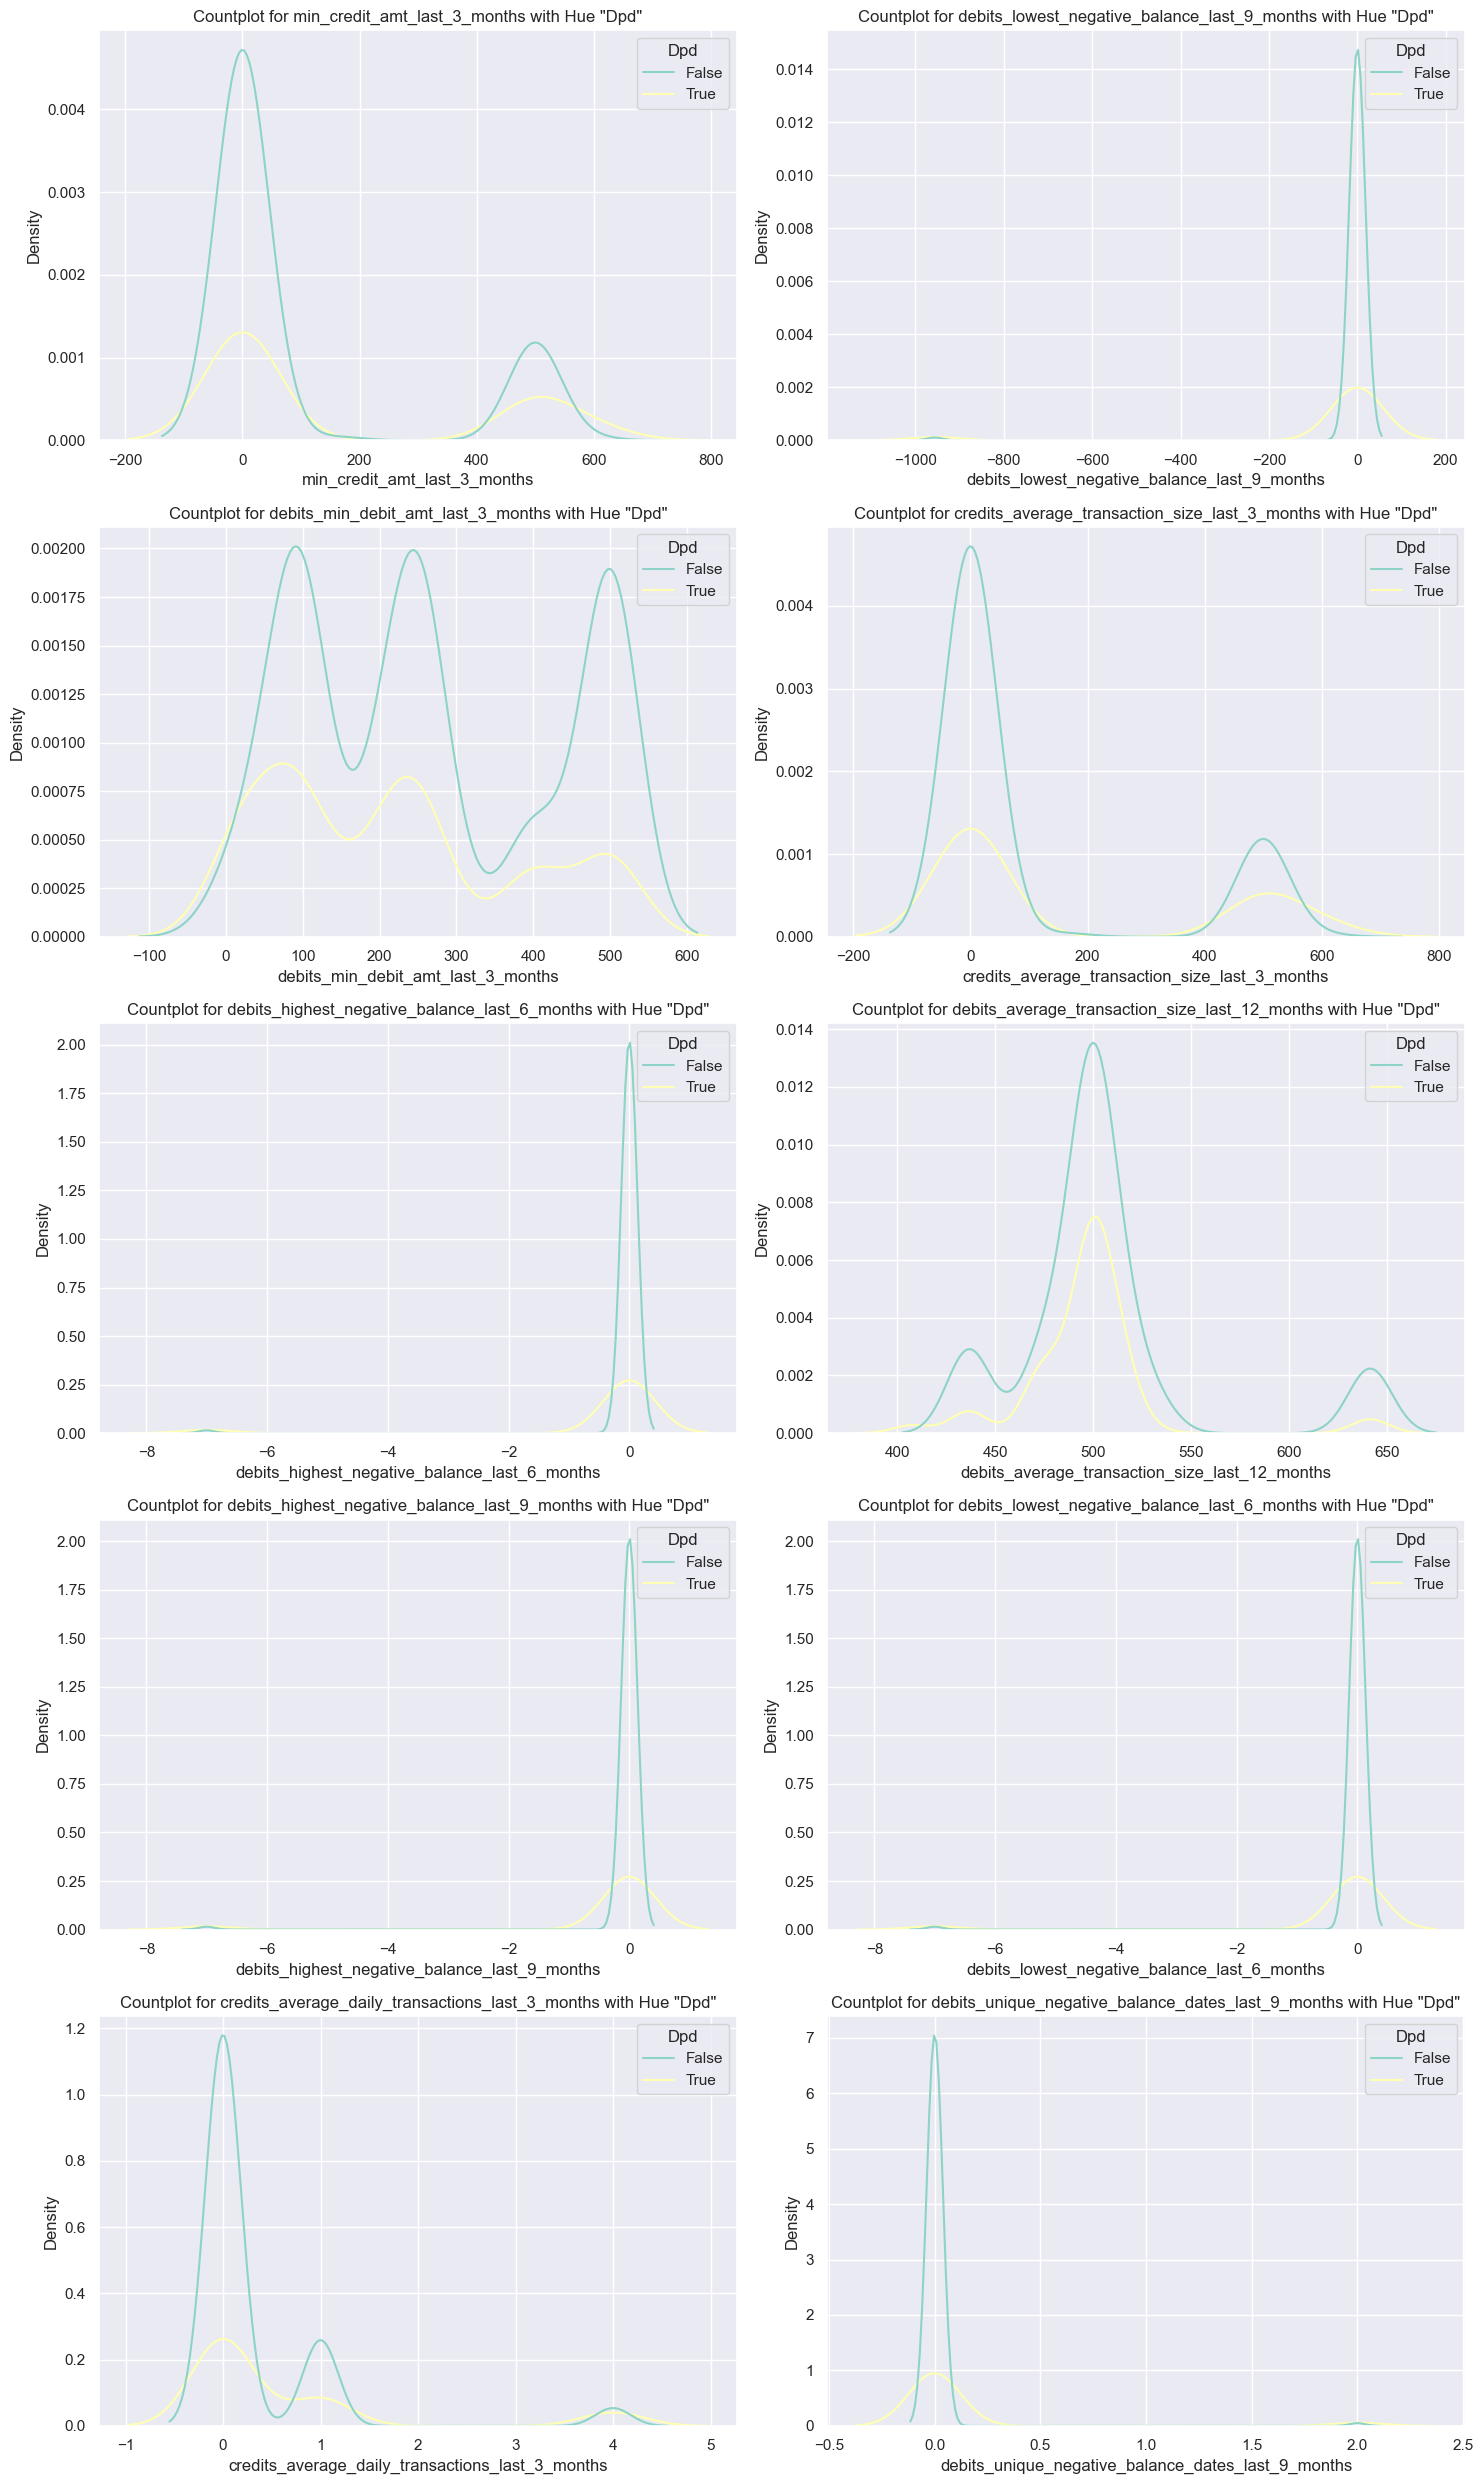

In [18]:
#Investigating feature relationships with Y

def X_y_relationship(data):
    data_cols = [col for col in data.columns if col != "Dpd"]
    
    data["Dpd"] = data["Dpd"].astype(str)
    num_cols = 2
    num_rows = (len(data_cols) + num_cols - 1) // num_cols  # Calculate the number of rows needed
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
    axes = axes.flatten()
    
    for i, col in enumerate(data_cols):
        sns.kdeplot(x=col, data=data, palette="Set3", hue="Dpd", ax=axes[i])
        axes[i].set_title(f'Countplot for {col} with Hue "Dpd"')
        
    for i in range(len(data_cols), len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    plt.show()
X_y_relationship=X_y_relationship(data)
X_y_relationship

In [51]:
#Label encode "DPd"
def Data_transformation(data):
 # Encoding
    encoder= LabelEncoder()
    data['Dpd'] = encoder.fit_transform(data[['Dpd']])
    # Scalling data
    cols_to_scale=['debits_min_debit_amt_last_3_months','debits_average_transaction_size_last_12_months']
    scaler = RobustScaler()
    data[cols_to_scale]=scaler.fit_transform(data[cols_to_scale])

    # Splitting ;Splitting Data- Hold-Out Validation
    X=data.drop('Dpd', axis=1).values
    y=data["Dpd"].values
    t_data=data
    print(f'X shape : {X.shape} \n y shape : {y.shape}')
    
    # train_test split
    X_train,X_test,y_train,y_test= train_test_split(X,y,train_size=0.9,test_size=0.1,random_state=0)
    print(f'X_train_shape :{X_train.shape}\n X_test-shape :{X_test.shape}\n y_train_shape: {y_train.shape}\ny_test_shape : {y_test.shape}')
    return X,y,X_train,X_test,y_train,y_test,t_data
X,y,X_train,X_test,y_train,y_test,t_data=Data_transformation(data)


 



X shape : (2420, 10) 
 y shape : (2420,)
X_train_shape :(2178, 10)
 X_test-shape :(242, 10)
 y_train_shape: (2178,)
y_test_shape : (242,)


###  Gradient Boosting  with XGBoost

In [31]:
# !conda install -c conda-forge xgboost -c defaults --no-Build_Type --no-use_CUDA


In [47]:
def xgboost_clf(X,y):
    classifier=xgboost.XGBClassifier(tree_method='hist')
    params={"learning_rate":[0.05,0.01,0.15,0.20,0.25,0.30],
           "max_depth":[2,3,4,5,6,8,10,12,13],
           "min_child_weight":[1,3,5,7],
           "gama":[0.0,0.1,0.2,0.3,0.4],
           "colsample_bytree":[0.3,0.4,0.5,0.7]}
    clf=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',cv=5,verbose=3)
    
    # fitting
    clf.fit(X,y)
    best_params=clf.best_params_
    best_estimator=clf.best_estimator_
    return best_params,best_estimator


                                 

In [34]:

# Confusion matrix
def plot_confusion_matrix(cm,classes=None,title='Confusion matrix'):
    if classes is not None:
        sns.heatmap(cm,cmap="YlGnBu",xticklabels=classes,yticklabels=classes,vmin=0,annot=True,annot_kws={'size':10})
    else:
        sns.heatmap(cm,vmin=0,vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Fitting the model with best parameters ( Getting Final Model)

In [49]:
#Best model
def final_xgboost_model(X,y):
    final_model=xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                  colsample_bynode=1, colsample_bytree=0.4,
                  enable_categorical=False, gama=0.3, gamma=0, gpu_id=-1,
                  importance_type=None, interaction_constraints='',
                  learning_rate=0.05, max_delta_step=0, max_depth=6,
                  min_child_weight=1, missing=np.nan, monotone_constraints='()',
                  n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
                  random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                  subsample=1, tree_method='hist', validate_parameters=1,
                  verbosity=None)
    #fitting the model
    final_model.fit(X,y)
    xboost_pred=final_model.predict(X)
    
    #ConfusionMatrix
    cm=confusion_matrix(y,xboost_pred)
    cm_norm=cm/cm.sum(axis=1)[:,np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm,classes=final_model.classes_)
    return cm,final_model



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 11 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   min_credit_amt_last_3_months                        2420 non-null   float64
 1   debits_lowest_negative_balance_last_9_months        2420 non-null   float64
 2   debits_min_debit_amt_last_3_months                  2420 non-null   float64
 3   credits_average_transaction_size_last_3_months      2420 non-null   float64
 4   debits_highest_negative_balance_last_6_months       2420 non-null   float64
 5   debits_average_transaction_size_last_12_months      2420 non-null   float64
 6   debits_highest_negative_balance_last_9_months       2420 non-null   float64
 7   debits_lowest_negative_balance_last_6_months        2420 non-null   float64
 8   credits_average_daily_transactions_last_3_months    2420 non-null   float64
 9

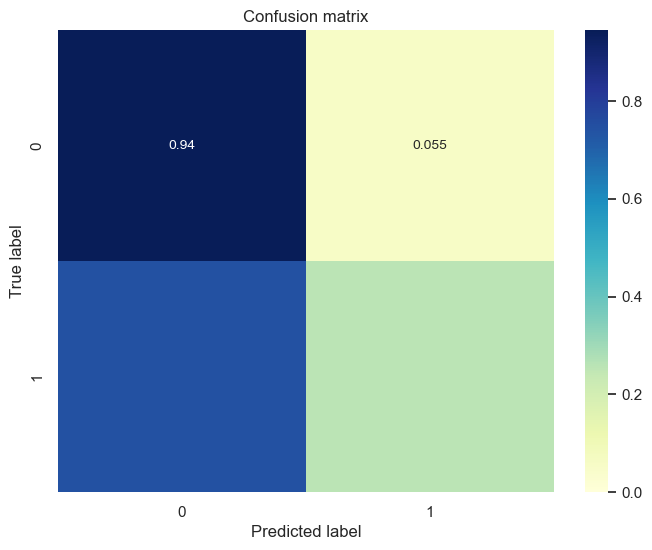

In [55]:
def call():
    data=data_ingestion()
    X,y,X_train,X_test,y_train,y_test,t_data=Data_transformation(data)
    best_params,best_estimator=xgboost_clf(X,y)
    cm,final_model=final_xgboost_model(X,y)
    return cm,final_model

cm,final_model=call()
